In [140]:
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
# %matplotlib inline

import pickle
import matplotlib.pyplot as plt
import os
from keras import models
from skimage.io import imread
from tensorflow.python.keras.utils.vis_utils import plot_model
from kb.generator.extract_class import extract_class, extract_class_muenze_group, remove_last, remove_first
import numpy as np
import cv2 as cv
from kb.generator.kariertes_blatt import get_data_objects_generator, get_seite_data_generator, \
    get_seite_data_objects_generator

plt.rcParams["figure.figsize"] = (10,10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Classification Task

### Prepare model and labels.

In [108]:

oben_model = models.load_model("models/classification_oben.hdf5")
seite_model = models.load_model("models/classification_seite.hdf5")
unter_model = models.load_model("models/classification_unter.hdf5")

with open('models/classification_oben_labels.hdf5') as f:
    oben_classes = [line.rstrip() for line in f]
with open('models/classification_seite_labels.hdf5') as f:
    seite_classes = [line.rstrip() for line in f]
with open('models/classification_unter_labels.hdf5') as f:
    unter_classes = [line.rstrip() for line in f]

### Layers

In [109]:
plot_model(oben_model, to_file='models/classification_model.png', dpi=70)
oben_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

## Training history
### Prepare history files

In [110]:
histories_path = [
    './models/classification_oben_history.hdf5',
    './models/classification_seite_history.hdf5',
    './models/classification_unter_history.hdf5'
]

histories = list(map(lambda path: pickle.load(open(path, "rb")), histories_path))

In [111]:
def graph_accuracy(history, name=""):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('Model accuracy of "' + name + '"')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def graph_loss(history, name=""):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Loss of "' + name + '"')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

### Show learning curve

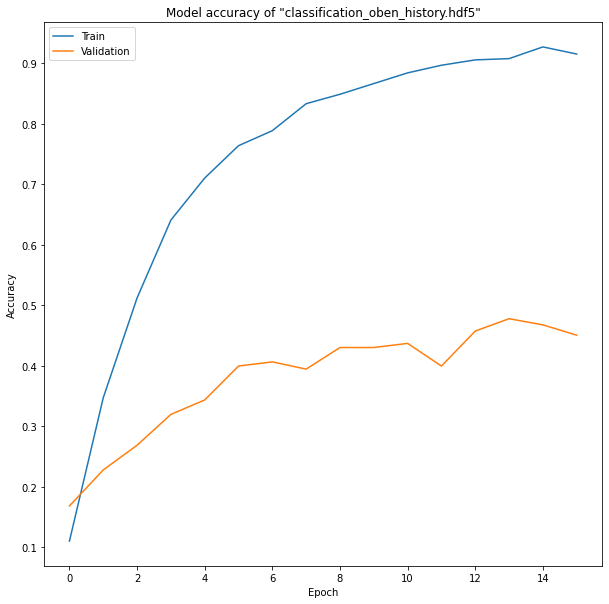

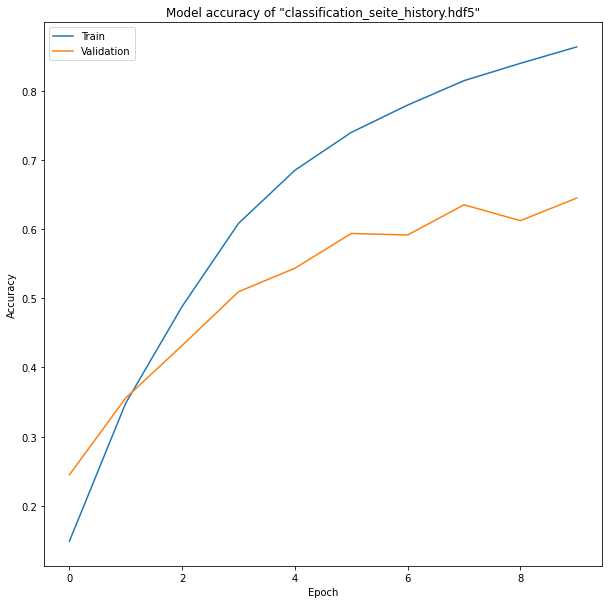

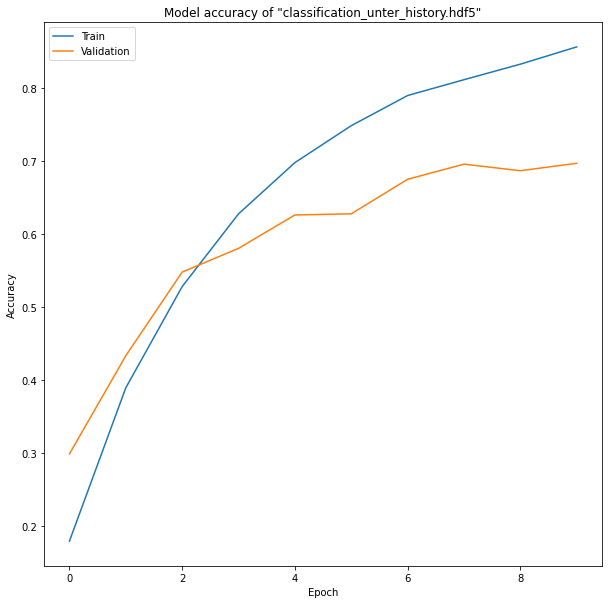

In [112]:
for history, path in zip(histories, histories_path):
    graph_accuracy(history, os.path.basename(path))

### Show loss curve

We use **sparse_categorical_crossentropy**.
https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other

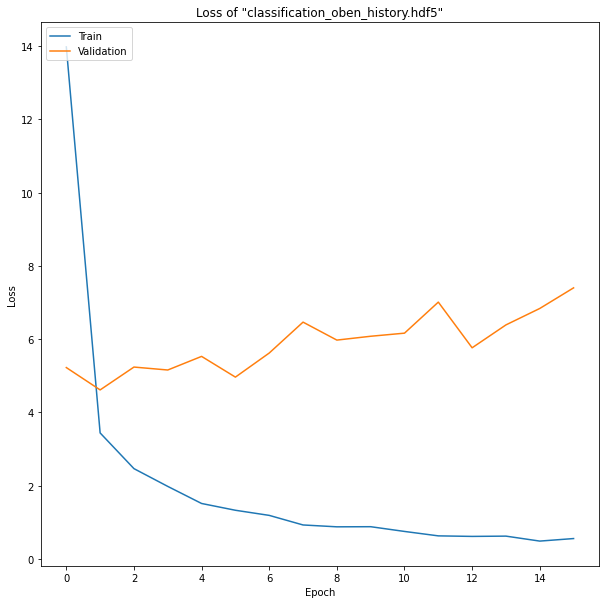

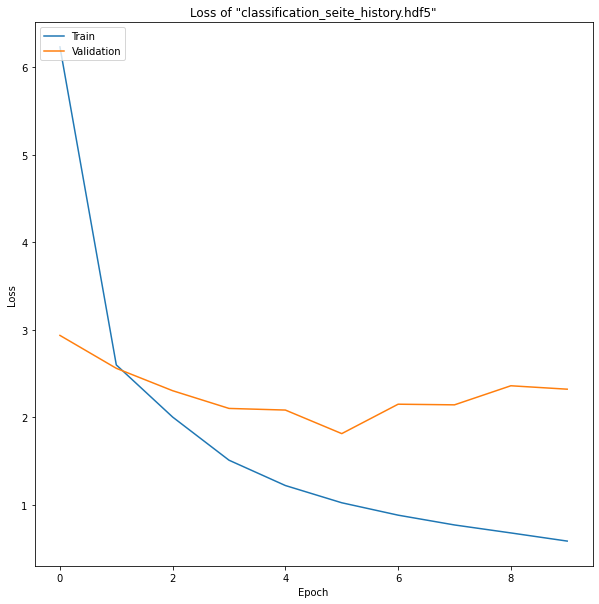

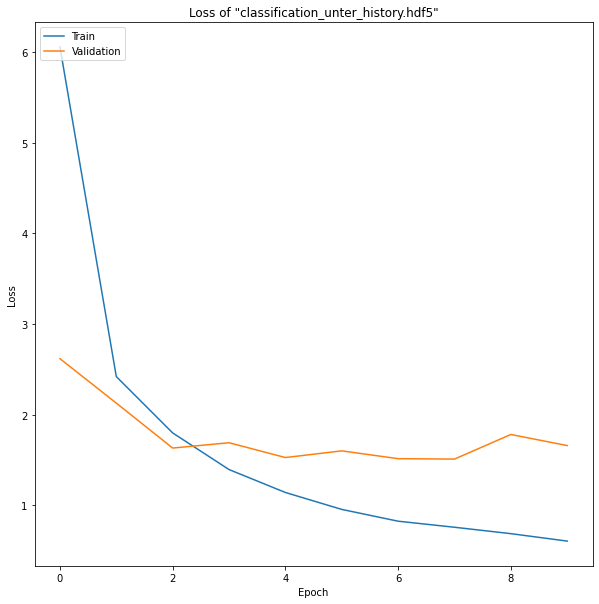

In [113]:
for history, path in zip(histories, histories_path):
    graph_loss(history, os.path.basename(path))

## Demo

### Load examples

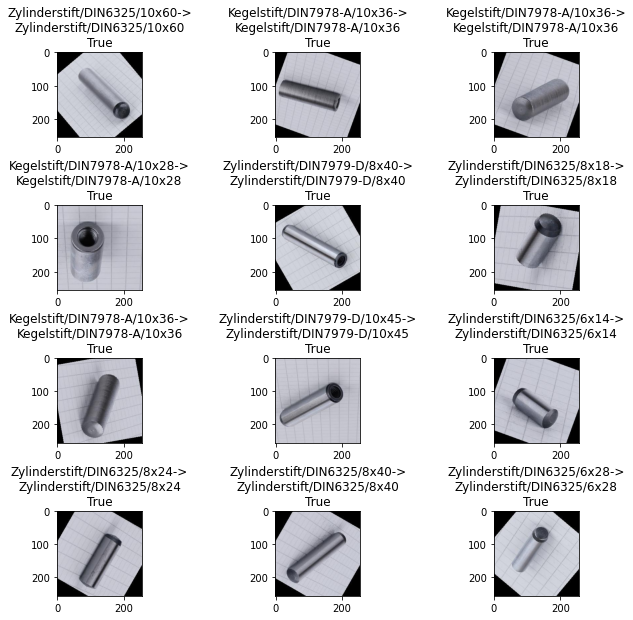

In [149]:
training_data, validation_data, _ = get_seite_data_objects_generator('./data/data_objects', classes=seite_classes)

def evaluation(image, model, classes, info, i):
    predicted_label = model.predict(np.array([image]))

    plt.subplot(4,3, i)
    plt.imshow(image)
    origin = remove_first(classes[info])
    target = remove_first(classes[np.argmax(predicted_label[0])])
    plt.title(origin + '->\n' + target + '\n' + str(origin == target))

examples = next(training_data)
for index, img, label in zip(range(len(examples[0])), examples[0], examples[1]):
    plt.subplots_adjust(hspace = 0.8, wspace=0.8)
    evaluation(img, seite_model, seite_classes, label, index+1)


### Testing with data from another group
#### Muenzen Group

In [116]:
root = "data/data_from_another_group/muenze"
data_path1 = root + "/Kegelstift/**/*_[0-9][0-9].JPG"
data_path2 = root + "/Zylinderstift/**/*_[0-9][0-9].JPG"
m_training, m_validation, classes = get_data_objects_generator(data_path1, data_path2, extract_class_func=extract_class_muenze_group, classes=seite_classes)
print(f"Number of classes: {len(classes)}")
print(f"Validation size: {len(m_validation)}")

Number of classes: 46
Validation size: 53


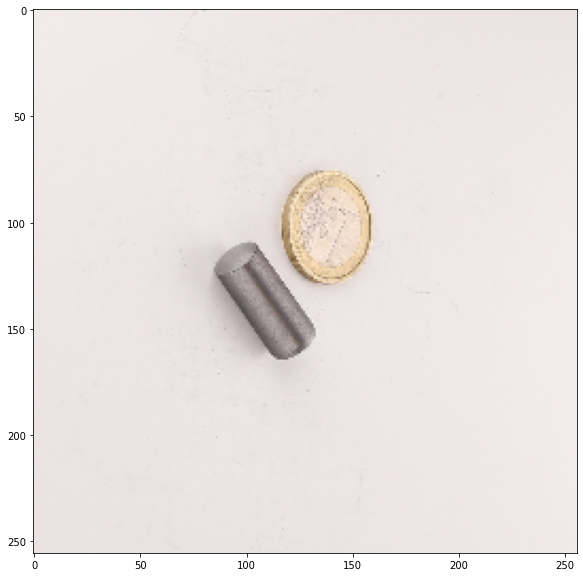

In [120]:
def image_preprocess(img):
    x = 1500
    y = 1500
    width, height, _ = img.shape
    img = img[int((width-x)/2):int((width+x)/2), int((height-y)/2):int((height+y)/2)]
    img = cv.resize(img, (256, 256))
    return img
m_validation.img_preprocess = image_preprocess

example = next(m_validation)
plt.imshow(example[0][0])

### Accuracy

In [123]:
def predicate(image, model, target, classes):
    predicted_label = model.predict(np.array([image]))
    return remove_first(remove_last(classes[target])) == remove_first(remove_last(classes[np.argmax(predicted_label[0])]))

p = 0
n = 0
for batch in tqdm(m_validation):
    for img, target in zip(batch[0], batch[1]):
        if predicate(img, seite_model, target, seite_classes):
            p += 1
        n += 1

print(f"Accuracy: {p/n}")

100%|██████████| 53/53 [03:33<00:00,  4.03s/it]


Accuracy: 0.4449685534591195


53


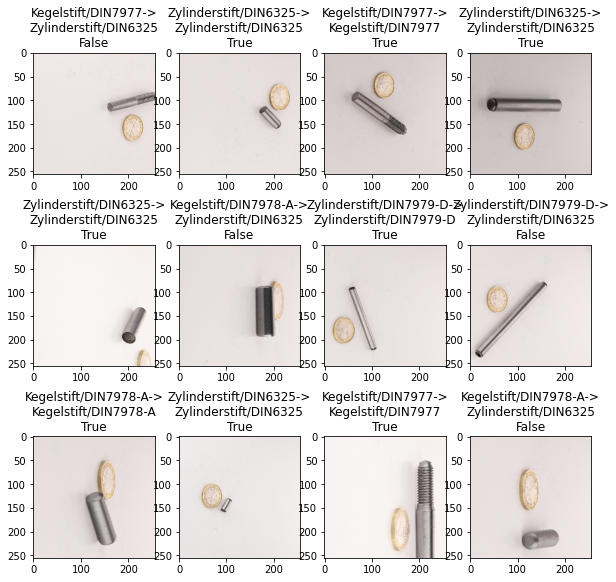

In [122]:
def evaluation(image, model, classes, info, i):
    predicted_label = model.predict(np.array([image]))

    plt.subplot(3,4, i)
    plt.imshow(image)
    origin = remove_last(remove_first(classes[info]))
    target = remove_last(remove_first(classes[np.argmax(predicted_label[0])]))
    plt.title(origin + '->\n' + target + '\n' + str(origin == target))

print(len(m_validation))
examples = next(m_validation)
for index, img, label in zip(range(len(examples[0])), examples[0], examples[1]):
    evaluation(img, seite_model, seite_classes, label, index+1)
